## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2019.

# Assignment 1, Task 3: Dimensionality Reduction

This task is devoted to dimensionality reduction. How to map high-dimensional data into low-dimensional space is an interesting topic in the machine learning field. It is related to another hot topic -- unsupervised learning. In this section, you are going to learn two different methods for this dimensionality reduction.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from utils.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

We will use the CIFAR-10 dataset.

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)

<span style="color:red"><strong>TODO</strong></span>: You have to complete the code in **./utils/features/pca.py**.

### Naive PCA

In [3]:
from utils.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))

In [4]:
# Start PCA
K = 300
P, T = pca_naive(X_patch, K)

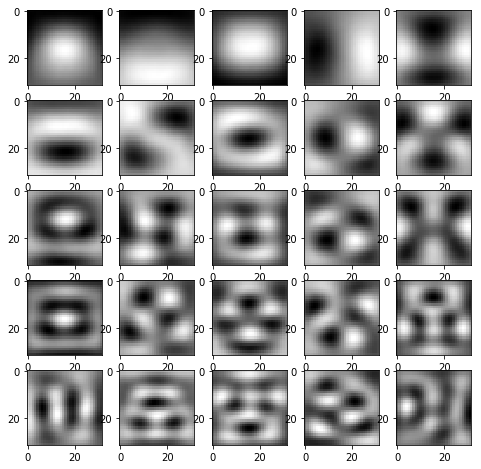

In [5]:
# Show principle components of P using a 5x5 subplot
# Visualize P
r = 5
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

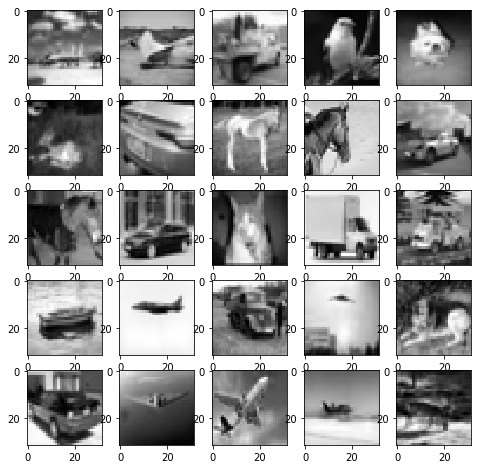

In [6]:
# Select a small set of images for test
num_training = 49000
num_pca = 25
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 5
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

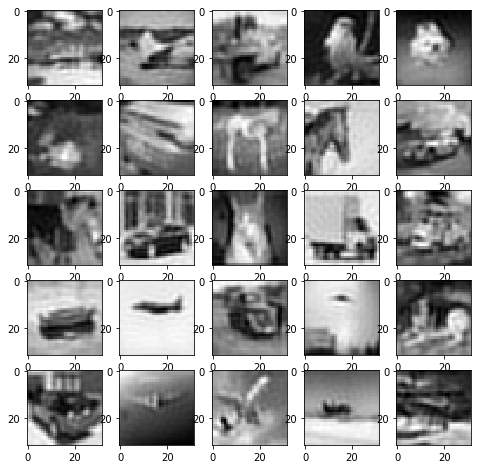

In [7]:
# Test your result
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 5
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

<span style="color:red"><strong>TODO</strong></span>: Use PCA to preprocess images before training a neural network: 

1. Do PCA preprocessing on each channel of the original image separately.
2. Stack PCA features from three channels into one vector, and use that vector as an input for MLP.
3. Train the MLP and show the results. 

In [12]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP

## TODO: pca preprocessing -> mlp classification
# Find the X_train number
num_training = 49000
num_validation = 1000
K = 300
X_store = []
X_store_test = []
N_train = X_train.shape[0]
N_test = X_test.shape[0]
for i in range(3):
    X_new = X_train[:,:,:,i].reshape(N_train,-1)
    X_new_test = X_test[:,:,:,i].reshape(N_test,-1)
    # Get the principle component and component vector by pca
    P_new,T_new = pca_naive(X_new,K)
    # Get img after transform with main features
    X_pca = X_new.dot(P_new.T)
    X_pca_test = X_new_test.dot(P_new.T)
    # Get stored
    X_store.append(X_pca)
    X_store_test.append(X_pca_test)

# Get the input for MLP and stack the feature from three dimensions
X_final_train = np.concatenate(X_store,axis=-1)
X_final_test = np.concatenate(X_store_test,axis=-1)
X_final_val = X_final_train[-num_validation:]
y_final_val = y_train[-num_validation:]
X_final_train = X_final_train[:num_training]

# We build the model here
model = MLP(input_dim=900,hidden_dims=[100, 100],num_classes=10,reg=0.1,weight_scale=1e-3)
num_epoch = 20
batch_size = 100
lr = 3e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_final_train, y_train, X_final_val, y_final_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
#Compute the test accuracy 
test_accuracy = test(model, X_final_test, y_test)

number of batches for training: 490
epoch 1: valid acc = 0.314, new learning rate = 0.028499999999999998
epoch 2: valid acc = 0.32, new learning rate = 0.027074999999999995
epoch 3: valid acc = 0.348, new learning rate = 0.025721249999999994
epoch 4: valid acc = 0.335, new learning rate = 0.024435187499999993
epoch 5: valid acc = 0.324, new learning rate = 0.023213428124999994
epoch 6: valid acc = 0.416, new learning rate = 0.022052756718749993
epoch 7: valid acc = 0.357, new learning rate = 0.020950118882812493
epoch 8: valid acc = 0.423, new learning rate = 0.01990261293867187
epoch 9: valid acc = 0.434, new learning rate = 0.018907482291738276
epoch 10: valid acc = 0.387, new learning rate = 0.01796210817715136
epoch 11: valid acc = 0.439, new learning rate = 0.01706400276829379
epoch 12: valid acc = 0.422, new learning rate = 0.0162108026298791
epoch 13: valid acc = 0.428, new learning rate = 0.015400262498385144
epoch 14: valid acc = 0.46, new learning rate = 0.014630249373465886


<span style="color:red"><strong>TODO</strong></span>: Plot training, validation and test set accuracy.

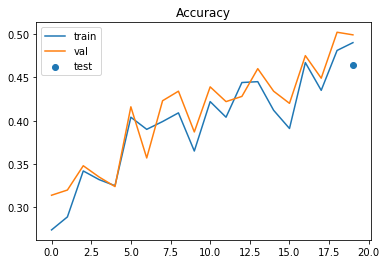

In [15]:
## TODO:
# plot the accuracy history
plt.title('Accuracy')
plt.plot(train_acc_hist,label='train')
plt.plot(val_acc_hist,label='val')
plt.scatter(19,test_accuracy,label='test')
plt.legend()
plt.show()

## Part 2: t-SNE (optional, bonus +10 points)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [18]:
from utils.features.tsne import tsne

#### tSNE of original data

In [19]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.552519987598942
The 100 th loop cost: 13.904532905994289, computation time: 2.260875701904297
The 200 th loop cost: 1.1297981240340178, computation time: 4.4868810176849365
The 300 th loop cost: 1.1248152381316348, computation time: 6.863452196121216
The 400 th loop cost: 1.1247279112939077, computation time: 9.178259372711182
The 500 th loop cost: 1.124727373077585, computation time: 12.4076247215271
The 600 th loop cost: 1.1247273717650335, computation time: 14.791262865066528
The 700 th loop cost: 1.124727371759586, computation time: 17.062178134918213
The 800 th loop cost: 1.1247273717595558, computation time: 19.904574632644653
The 900 th loop cost: 1.1247273717595552, computation time: 22.19497299194336
The 1000 th loop cost: 1.124727371759555, computation time: 24.422020435333252
it takes 24.98587942123413 seconds


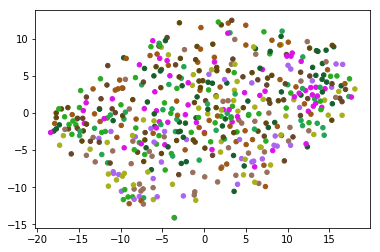

In [20]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other. While the tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [ ]:
# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

<span style="color:red"><strong>TODO</strong></span>: Do visualization of the tSNE of data after going through MLP. 

In [ ]:
# run tSNE
X = X_test[random_select]
tic = time.time()
# TODO:
# You need to first go through two hidden layers.




# End TODO
print("it takes {} seconds".format(time.time()-tic))

In [ ]:
# TODO:
# visualize tSNE 2D representation of data after two hidden layers

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [ ]:
# TODO:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]




print("it takes {} seconds".format(time.time()-tic))

In [ ]:
# TODO:
# visualize tSNE 2D representation of data after two hidden layers